## Setup

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
cd "/content/gdrive/My Drive/mini"

/content/gdrive/My Drive/mini


In [3]:
import torch
from PIL import Image
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import os
import matplotlib.pyplot as plt
import torch.nn as nn
from torch import optim

In [4]:
## use gpu

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


## Data Loading

In [5]:
def read_images_from_folder(folder_path):

    image_files = sorted([f for f in os.listdir(folder_path) if f.endswith('.png')])

    images = []

    for filename in image_files:
        file_path = os.path.join(folder_path, filename)
        if os.path.isfile(file_path):
            image = Image.open(file_path)
            images.append(image)

    return images


In [6]:
## this is to load the images
trainfolder_path = "./data/tsrd-train"
testfolder_path = "./data/TSRD-Test"

train_images = read_images_from_folder(trainfolder_path)
test_images = read_images_from_folder(testfolder_path)


In [7]:
print("number of train image is " + str(len(train_images)))
print("number of train image is " + str(len(test_images)))

number of train image is 4170
number of train image is 1994


In [8]:
def extract_label(file_path):
    # Define the path to your text file
    file_path = file_path  # Replace with the actual path to your text file

    # Open the text file and read it line by line
    with open(file_path, 'r') as file:
        lines = file.readlines()

    # Sort the lines lexicographically
    sorted_lines = sorted(lines)


    eighth_elements = []
    for line in sorted_lines:
      # Remove leading/trailing whitespaces and split the line by ';'
      elements = line.strip().split(';')
      # Check if the line has at least 8 elements
      if len(elements) >= 8:
          # Extract the eighth element (index 7) and append to the list
          eighth_elements.append(int(elements[7]))
      else:
          # If the line does not have at least 8 elements, append None
          eighth_elements.append(None)
    return eighth_elements




In [9]:
# this is to load the labels
trainfile_path = "./data/TSRD-Train Annotation/TsignRecgTrain4170Annotation.txt"
testfile_path = "./data/TSRD-Test Annotation/TsignRecgTest1994Annotation.txt"

train_label = extract_label(trainfile_path)
test_label = extract_label(testfile_path)

In [10]:
print("number of train label is " + str(len(train_label)))
print("number of test label is " + str(len(test_label)))

number of train label is 4170
number of test label is 1994


## Custom Dataset

In [11]:
#Create Dataset

class CustomDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform


    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        sample = self.data[index]
        label = self.labels[index]

        if self.transform:
            sample = self.transform(sample)

        return sample, label


## Get mean and std based on the training set

In [12]:
inputsize = (224,224)

transformTensor = transforms.Compose([

  # Resize image
  transforms.Resize(inputsize),

  # Convert the image to a PyTorch tensor
    transforms.ToTensor(),
])



In [13]:
trainset = CustomDataset(train_images, train_label, transform=transformTensor)

In [14]:
# Calculate mean and std from the training dataset
mean = torch.zeros(3)  # Assuming RGB images, adjust the dimension if needed
std = torch.zeros(3)

for img, _ in trainset:
    mean += img.mean(dim=(1, 2))
    std += img.std(dim=(1, 2))

mean /= len(trainset)
std /= len(trainset)

In [15]:
print("mean is : ", mean)
print("std is : ", std)

mean is :  tensor([0.4323, 0.4204, 0.4275])
std is :  tensor([0.1888, 0.1850, 0.1884])


## Data Augmentation and Data Loader

In [16]:
inputsize = (224,224)

transformTrain = transforms.Compose([
    # Resize the image
    transforms.Resize(inputsize),

    # Blur the image
    transforms.GaussianBlur(kernel_size = (5,5)),

    # Convert the image to a PyTorch tensor
    transforms.ToTensor(),

    # Normalize the pixel values
    transforms.Normalize(mean, std)

])

## seperate because test no need blur
transformTest = transforms.Compose([
    # Resize the image to the desired size
    transforms.Resize(inputsize),

    # Convert the image to a PyTorch tensor
    transforms.ToTensor(),

    # Normalize the pixel values
    transforms.Normalize(mean, std)

])

In [17]:
trainset = CustomDataset(train_images, train_label, transform=transformTrain)
testset = CustomDataset(test_images,test_label,transform= transformTest)

batch_size = 32

train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(testset, batch_size = batch_size,shuffle=True)

## Ensure code above works well

In [18]:
print(len(trainset))

4170


In [19]:
print(len(trainset.labels))

4170


In [20]:
print(trainset.data)

[<PIL.PngImagePlugin.PngImageFile image mode=RGB size=134x128 at 0x7866B020FA00>, <PIL.PngImagePlugin.PngImageFile image mode=RGB size=165x151 at 0x7866B02BC4F0>, <PIL.PngImagePlugin.PngImageFile image mode=RGB size=128x122 at 0x7866B020F910>, <PIL.PngImagePlugin.PngImageFile image mode=RGB size=121x100 at 0x7866B02BC6D0>, <PIL.PngImagePlugin.PngImageFile image mode=RGB size=120x102 at 0x7866B02BC250>, <PIL.PngImagePlugin.PngImageFile image mode=RGB size=123x108 at 0x7866B02BC640>, <PIL.PngImagePlugin.PngImageFile image mode=RGB size=127x114 at 0x7866B020F730>, <PIL.PngImagePlugin.PngImageFile image mode=RGB size=77x69 at 0x7866B02BC730>, <PIL.PngImagePlugin.PngImageFile image mode=RGB size=142x130 at 0x7866B02BC7C0>, <PIL.PngImagePlugin.PngImageFile image mode=RGB size=81x67 at 0x7866B02BC820>, <PIL.PngImagePlugin.PngImageFile image mode=RGB size=80x73 at 0x7866B02BC880>, <PIL.PngImagePlugin.PngImageFile image mode=RGB size=186x174 at 0x7866B02BC520>, <PIL.PngImagePlugin.PngImageFile 

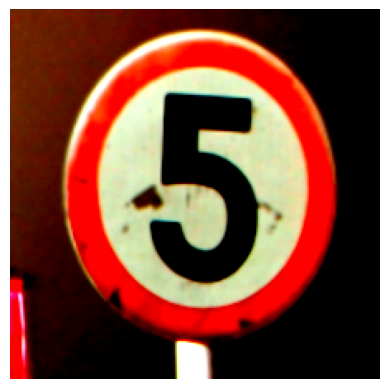

0
(224, 224, 3)


In [21]:
outimage, outlabel = trainset[0]
outimage = outimage.numpy()

if outimage.shape[0] == 3:
    outimage = outimage.transpose(1, 2, 0)

plt.imshow(outimage)
plt.axis('off')  # Optional: Turn off axis
plt.show()
print(outlabel)
print(outimage.shape)

## Train and validate function

In [22]:


def train_and_validate(net, trainloader, testloader, optimizer,scheduler, criterion, num_epochs,netName):


    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []

    # Transfer model to GPU if available
    if torch.cuda.is_available():
        net = net.cuda()

    # Set model to training mode
    net.train()

    for epoch in range(num_epochs):
        running_train_loss = 0.0
        running_train_correct = 0
        running_train_total = 0

        for i, (inputs, labels) in enumerate(trainloader):
            optimizer.zero_grad()

            if torch.cuda.is_available():
                inputs = inputs.cuda()
                labels = labels.cuda()

            outputs = net(inputs)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_train_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            running_train_total += labels.size(0)
            running_train_correct += (predicted == labels).sum().item()

        train_loss = running_train_loss / len(trainloader)
        train_accuracy = 100.0 * running_train_correct / running_train_total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Validation
        net.eval()  # Set model to evaluation mode
        running_test_loss = 0.0
        running_test_correct = 0
        running_test_total = 0

        with torch.no_grad():
            for inputs, labels in testloader:
                if torch.cuda.is_available():
                    inputs = inputs.cuda()
                    labels = labels.cuda()

                outputs = net(inputs)
                loss = criterion(outputs, labels)

                running_test_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                running_test_total += labels.size(0)
                running_test_correct += (predicted == labels).sum().item()

        test_loss = running_test_loss / len(testloader)
        test_accuracy = 100.0 * running_test_correct / running_test_total
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)

        print(f'Epoch {epoch + 1}/{num_epochs}: '
              f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, '
              f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

        scheduler.step()

        if (epoch % 3 ==0):
          ## save each epoch of model
          model_path = './model/'+str(epoch+1) + netName +'.pth'
          torch.save(net,model_path)

        net.train()  # Set model back to training mode

    return train_losses, train_accuracies, test_losses, test_accuracies


## Model selection VGG16

In [23]:
from torchvision.models.vgg import VGG16_Weights
from torchvision.models import vgg16

vgg = vgg16(weights= VGG16_Weights.IMAGENET1K_V1)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:04<00:00, 135MB/s]


In [24]:
print(vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [25]:
# is to freeze layer
parameters = list(vgg.parameters())
for param in parameters[:-6]:
  param.requires_grad = False

In [26]:
# use to check each freeze state of each layer
for name, param in vgg.named_parameters():
  print(name, ':', param.requires_grad)

features.0.weight : False
features.0.bias : False
features.2.weight : False
features.2.bias : False
features.5.weight : False
features.5.bias : False
features.7.weight : False
features.7.bias : False
features.10.weight : False
features.10.bias : False
features.12.weight : False
features.12.bias : False
features.14.weight : False
features.14.bias : False
features.17.weight : False
features.17.bias : False
features.19.weight : False
features.19.bias : False
features.21.weight : False
features.21.bias : False
features.24.weight : False
features.24.bias : False
features.26.weight : False
features.26.bias : False
features.28.weight : False
features.28.bias : False
classifier.0.weight : True
classifier.0.bias : True
classifier.3.weight : True
classifier.3.bias : True
classifier.6.weight : True
classifier.6.bias : True


In [27]:
##new classifcation  layer

classifier = torch.nn.Sequential(
    torch.nn.Linear(25088, 4096),
    torch.nn.ReLU(inplace=True),
    torch.nn.Dropout(p=0.5),
    torch.nn.Linear(4096, 4096),
    torch.nn.ReLU(inplace=True),
    torch.nn.Dropout(p=0.5),
    torch.nn.Linear(4096, 58)
)

In [28]:
# Replace the classifier of the pretrained model with the new one
vgg.classifier = classifier

In [29]:
## modify output layer
num_classes = 58
in_c = vgg.classifier[6].in_features

vgg.classifier[6] = nn.Linear(in_c,num_classes)

In [30]:
# check output layer
print(vgg.classifier[-1])

Linear(in_features=4096, out_features=58, bias=True)


## Set optimizer, loss function

In [31]:
vgg_optimizer = optim.SGD(vgg.parameters(),lr = 0.001, momentum = 0.9)

In [32]:
from torch.optim import lr_scheduler
import torch.nn.functional as F

vgg_scheduler = lr_scheduler.StepLR(vgg_optimizer,step_size = 60, gamma = 0.1)

In [33]:
criterion = nn.CrossEntropyLoss()

In [34]:
Vtrain_losses, Vtrain_accuracies, Vtest_losses, Vtest_accuracies =  train_and_validate(vgg, train_loader,test_loader, vgg_optimizer,vgg_scheduler, criterion, 30, 'Vgg')

Epoch 1/30: Train Loss: 2.4824, Train Accuracy: 43.24%, Test Loss: 2.2454, Test Accuracy: 46.24%
Epoch 2/30: Train Loss: 0.8164, Train Accuracy: 82.40%, Test Loss: 1.5884, Test Accuracy: 61.18%
Epoch 3/30: Train Loss: 0.3909, Train Accuracy: 92.16%, Test Loss: 1.4336, Test Accuracy: 62.19%
Epoch 4/30: Train Loss: 0.2199, Train Accuracy: 95.73%, Test Loss: 1.2805, Test Accuracy: 62.89%
Epoch 5/30: Train Loss: 0.1433, Train Accuracy: 97.77%, Test Loss: 1.2353, Test Accuracy: 64.59%
Epoch 6/30: Train Loss: 0.0958, Train Accuracy: 98.73%, Test Loss: 1.1215, Test Accuracy: 68.81%
Epoch 7/30: Train Loss: 0.0676, Train Accuracy: 99.30%, Test Loss: 1.0954, Test Accuracy: 69.91%
Epoch 8/30: Train Loss: 0.0509, Train Accuracy: 99.54%, Test Loss: 1.1072, Test Accuracy: 66.80%
Epoch 9/30: Train Loss: 0.0377, Train Accuracy: 99.71%, Test Loss: 1.0548, Test Accuracy: 70.21%
Epoch 10/30: Train Loss: 0.0302, Train Accuracy: 99.86%, Test Loss: 1.0735, Test Accuracy: 70.11%
Epoch 11/30: Train Loss: 0.02

## Save train and test data ## useless

In [ ]:
import csv

TrainTestData = [Vtrain_losses, Vtrain_accuracies, Vtest_losses, Vtest_accuracies]

file_path = 'TrainTestData.csv'

with open(file_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(TrainTestData)


## if want to read
# import csv

# # Specify the file path where the CSV file is located
# file_path = 'data.csv'  # Replace with the actual file path

# # Initialize empty lists to store the data
# list1 = []
# list2 = []
# list3 = []
# list4 = []

# # Read data from the CSV file
# with open(file_path, mode='r') as file:
#     reader = csv.reader(file)
#     for row in reader:
#         # Extract values from each row and append them to the respective lists
#         list1.append(int(row[0]))
#         list2.append(row[1])
#         list3.append(float(row[2]))
#         list4.append(row[3])

# # Now, list1, list2, list3, and list4 contain the data from the CSV file


## Plot Learning graph

In [35]:
import matplotlib.pyplot as plt

def plot_metrics(train_losses, test_losses, train_accuracies, test_accuracies):
    # Plot training and validation losses
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss', marker='o')
    plt.plot(test_losses, label='Test Loss', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Test Loss')
    plt.legend()

    # Plot training and validation accuracies
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy', marker='o')
    plt.plot(test_accuracies, label='Test Accuracy', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Test Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Example usage:
# Assuming you have lists train_losses, test_losses, train_accuracies, and test_accuracies
# plot_metrics(train_losses, test_losses, train_accuracies, test_accuracies)


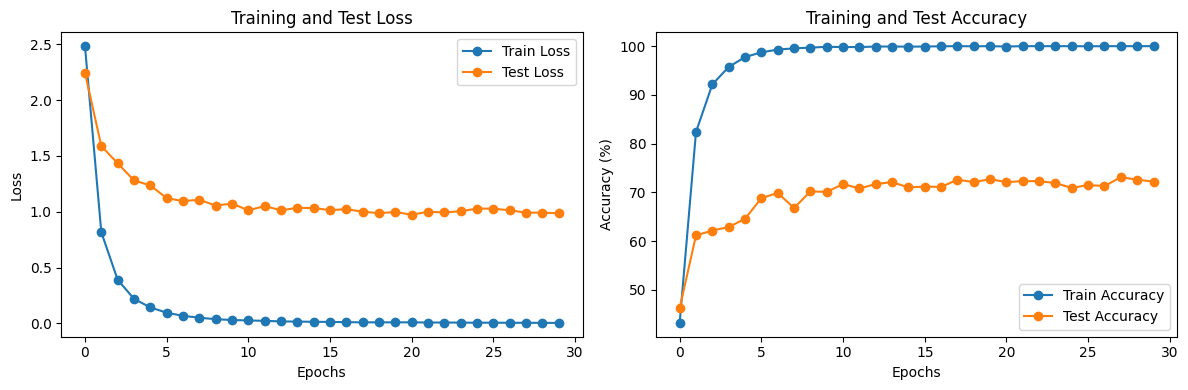

In [36]:
plot_metrics(Vtrain_losses, Vtest_losses, Vtrain_accuracies, Vtest_accuracies)


## Selection of model based on epoch

In [38]:
vgg = torch.load("./model/28Vgg.pth")

##Fine tune whole model

In [39]:
vgg_optimizer = optim.SGD(vgg.parameters(),lr = 0.001, momentum = 0.9)

In [40]:
from torch.optim import lr_scheduler
import torch.nn.functional as F

vgg_scheduler = lr_scheduler.StepLR(vgg_optimizer,step_size = 60, gamma = 0.1)

In [41]:
# is to freeze the layer but useless here
parameters = list(vgg.parameters())
for param in parameters[:-6]:
  param.requires_grad = True

In [42]:
# use to check each freeze state of each layer
for name, param in vgg.named_parameters():
  print(name, ':', param.requires_grad)

features.0.weight : True
features.0.bias : True
features.2.weight : True
features.2.bias : True
features.5.weight : True
features.5.bias : True
features.7.weight : True
features.7.bias : True
features.10.weight : True
features.10.bias : True
features.12.weight : True
features.12.bias : True
features.14.weight : True
features.14.bias : True
features.17.weight : True
features.17.bias : True
features.19.weight : True
features.19.bias : True
features.21.weight : True
features.21.bias : True
features.24.weight : True
features.24.bias : True
features.26.weight : True
features.26.bias : True
features.28.weight : True
features.28.bias : True
classifier.0.weight : True
classifier.0.bias : True
classifier.3.weight : True
classifier.3.bias : True
classifier.6.weight : True
classifier.6.bias : True


In [43]:
VFtrain_losses, VFtrain_accuracies, VFtest_losses, VFtest_accuracies =  train_and_validate(vgg, train_loader,test_loader, vgg_optimizer,vgg_scheduler, criterion, 30, 'VggF')

Epoch 1/30: Train Loss: 0.0022, Train Accuracy: 100.00%, Test Loss: 1.0180, Test Accuracy: 73.12%
Epoch 2/30: Train Loss: 0.0011, Train Accuracy: 100.00%, Test Loss: 0.9970, Test Accuracy: 74.22%
Epoch 3/30: Train Loss: 0.0008, Train Accuracy: 100.00%, Test Loss: 0.9796, Test Accuracy: 75.73%
Epoch 4/30: Train Loss: 0.0006, Train Accuracy: 100.00%, Test Loss: 1.0127, Test Accuracy: 74.32%
Epoch 5/30: Train Loss: 0.0008, Train Accuracy: 100.00%, Test Loss: 1.0671, Test Accuracy: 73.92%
Epoch 6/30: Train Loss: 0.0017, Train Accuracy: 99.93%, Test Loss: 0.9978, Test Accuracy: 75.33%
Epoch 7/30: Train Loss: 0.0006, Train Accuracy: 99.98%, Test Loss: 1.0385, Test Accuracy: 74.32%
Epoch 8/30: Train Loss: 0.0003, Train Accuracy: 100.00%, Test Loss: 1.0371, Test Accuracy: 74.72%
Epoch 9/30: Train Loss: 0.0007, Train Accuracy: 99.98%, Test Loss: 0.9935, Test Accuracy: 75.73%
Epoch 10/30: Train Loss: 0.0002, Train Accuracy: 100.00%, Test Loss: 0.9869, Test Accuracy: 75.93%
Epoch 11/30: Train Los

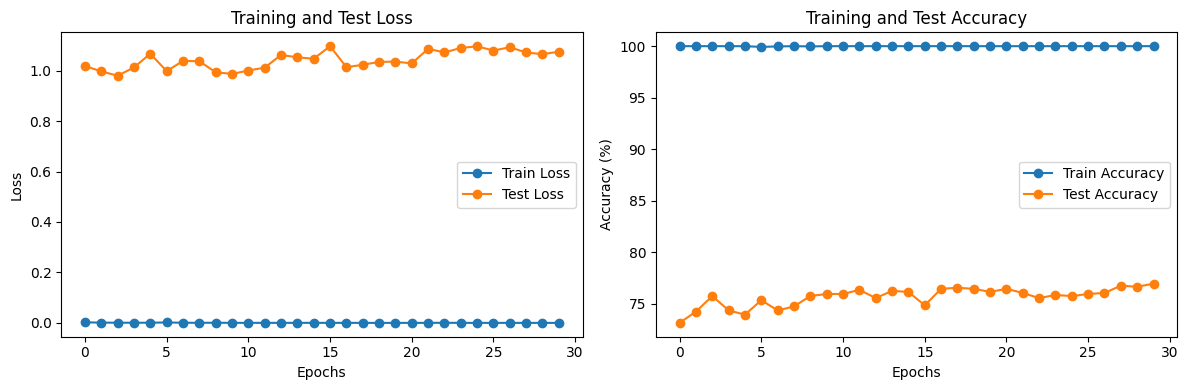

In [45]:
plot_metrics(VFtrain_losses, VFtest_losses, VFtrain_accuracies, VFtest_accuracies)